# Electricity data

In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
from io import StringIO
import requests
import json
import plotly.express as px
import ipywidgets as widgets
from datetime import datetime,date
import pytz
import matplotlib.dates as mdates
import plotly.graph_objects as go
from plotly.subplots import make_subplots



Populating the interactive namespace from numpy and matplotlib


data obtained from here https://transparency.entsoe.eu/
Potentially interesting library: https://facebook.github.io/prophet/docs/quick_start.html

                     day-ahead   actual
daytime                                
2020-01-01 00:00:00    10686.0  10798.0
2020-01-01 01:00:00    10150.0  10310.0
2020-01-01 02:00:00     9665.0   9748.0
2020-01-01 03:00:00     9308.0   9205.0
2020-01-01 04:00:00     9225.0   9014.0


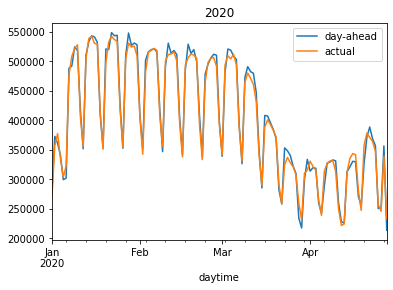

In [3]:
today = date.today()
def getLoadData(filename):
    df = pd.read_csv(filename, na_values='-')
    df = df.replace('-', None)
    df = df.dropna()
    df.rename(columns={ df.columns[0]: "daytime", df.columns[1]: "day-ahead", df.columns[2]: "actual" }, inplace = True)
    df['daytime'] = df['daytime'].str.slice(0,16)
    df.drop(df.index[2])
    df["daytime"] = pd.to_datetime(df["daytime"], format="%d.%m.%Y %H:%M")
    df['actual'] = pd.to_numeric(df["actual"])
    df['day-ahead'] = pd.to_numeric(df["day-ahead"])
    df = df.set_index('daytime')
#     df = df.resample('D', label='left').sum()
#     df = df.drop(df.index[0]) #to avoid half weeks
#     df = df.drop(df.index[-1]) #to avoid half weeks
    df
    return df

filename20 = "data/italy/north-2020.csv"
filename19 = "data/italy/north-2019.csv"

df19 = getLoadData(filename19)
df20 = getLoadData(filename20)
print(df20.head())
df20.resample('D', label='left').sum().plot(title="2020")


In [55]:
df= df20
df = df.reset_index()
#hours = pd.to_datetime(df.daytime)


def daily_pattern(df1,df2, title):
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=df1.index, y=df1['actual'], line=dict(color='royalblue', width=2),
                                name="actual (before lockdown)"))
    fig.add_trace(go.Scatter(x=df1.index, y=df1['day-ahead'], line=dict(color='royalblue', width=2, dash='dash'),
                                name="day-ahead (before lockdown)"))
    fig.add_trace(go.Scatter(x=df2.index, y=df2['actual'], line=dict(color='green', width=2),
                                name="actual (during lockdown)"))
    fig.add_trace(go.Scatter(x=df2.index, y=df2['day-ahead'], line=dict(color='green', width=2,  dash='dash'),
                                name="day-ahead (during lockdown)"))
    fig.update_layout(
            title={
                'text': title,
                'y':0.9,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'})
    fig.show()


title20 = "Italy 2020: Load patterns before and during quarantine"
df201 = df20.loc[(df20.index < datetime(2020,3,9))]
df201 = df201.groupby(df201.index.hour).mean()
df202 = df20.loc[(df20.index >= datetime(2020,3,9)) & (df20.index <= datetime(2020,5,3))]
df202 = df202.groupby(df202.index.hour).mean()
daily_pattern(df201,df202, title20)

title19 = "Italy 2019: Load patterns at times corresponding to before and during quarantine 2019"
df191 = df19.loc[(df19.index < datetime(2019,3,9))]
df191 = df191.groupby(df191.index.hour).mean()
df192 = df19.loc[(df19.index >= datetime(2019,3,9)) & (df19.index <= datetime(2019,5,3))]
df192 = df192.groupby(df192.index.hour).mean()
daily_pattern(df191,df192, title19)
                  

# df["dow"] = df["created_at"].apply(lambda d: d.weekday())
# df["hour"] = df["created_at"].apply(lambda d: d.hour)
# df["minute"] = df["created_at"].apply(lambda d: d.minute)
# df["time_week"] = df["dow"]*24 + df["hour"] + df["minute"]/60.

In [40]:


def timeline(df, title, with_annotation=True):
    df_daily = df.resample('D', label='left').sum()
    df_daily = df_daily[:-1]
    # Add traces
    i = 0
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=df_daily.index, y=df_daily["day-ahead"],
                             line=dict(color='coral', width=2),
                            name="day-ahead"))
    fig.add_trace(go.Scatter(x=df_daily.index, y=df_daily["actual"],
                             line=dict(color='royalblue', width=2),
                             name="actual")) 
    
    df_weekly = df_daily.resample('W', label='left').mean()
    df_weekly = df_weekly[1:]
   
    fig.add_trace(go.Scatter(x=df_weekly.index, y=df_weekly["day-ahead"],
                             line=dict(color='coral', width=3, dash='dash'),
                            name="day-ahead (weekly mean)"))
    fig.add_trace(go.Scatter(x=df_weekly.index, y=df_weekly["actual"],
                             line=dict(color='royalblue', width=3, dash='dash'),
                            name="actual (weekly mean)"))  
    if with_annotation: 
        fig.add_annotation(x=datetime(2020,3,9),y=200000,text="lockdown",ax=0,ay=-350, arrowcolor="#636363", opacity=0.8)
    fig.update_layout(title={
        'text': title,
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
    fig.show()

timeline(df20, title="Electricity Load of North Italy 2020")
df19 = df19.loc['2019-01-01':'2019-05-30']
timeline(df19, title="Electricity Load of North Italy 2019", with_annotation= False)

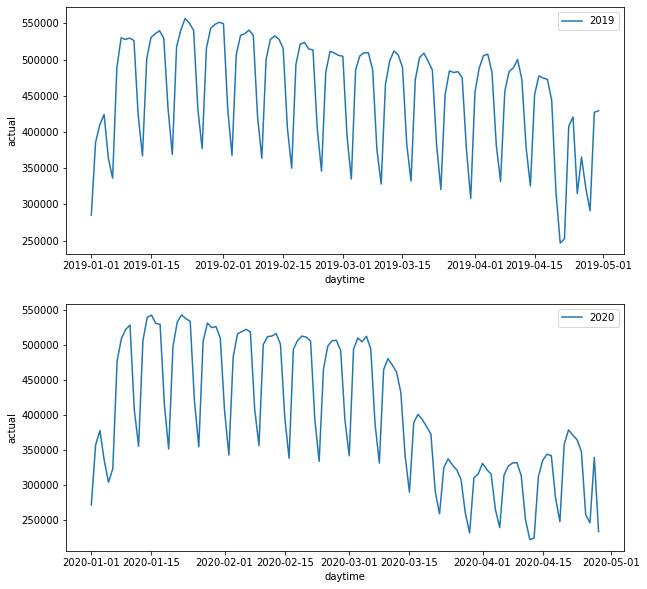

In [90]:
# fig = px.line(x=df20.index, y=df20['actual'])
# fig = px.line(x=df20.index, y=df20['actual'])
# df20 = df20.resample('W-Mon', label='left').mean()
# df19 = df19.resample('W-Mon', label='left').mean()

fig, ax = plt.subplots(2, 1, figsize=(10,10))
# ax = axs.flatten()[]
sns.lineplot(x=df19.index, y=df19['actual'], ci=95, ax=ax[0], label="2019")

sns.lineplot(x=df20.index, y=df20['actual'], ci=95, ax=ax[1], label="2020")

# #fig.show()

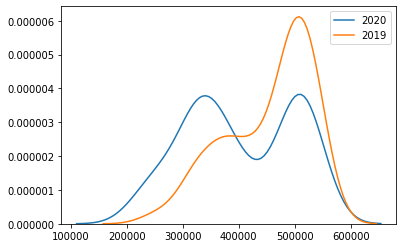

In [4]:
sns.kdeplot(df20['actual'],label="2020")
sns.kdeplot(df19['actual'],label="2019")

,day-ahead,actual
daytime,,
2020-01-01,552273.0,553048.0
2020-01-02,729209.0,698504.0
2020-01-03,706995.0,723906.0
2020-01-04,666109.0,662006.0
2020-01-05,606713.0,605395.0


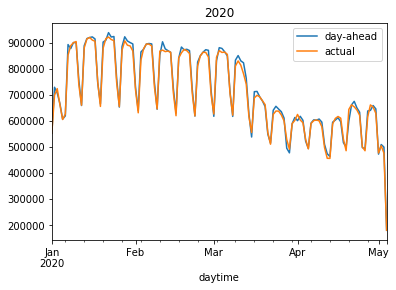

In [5]:
it20 = "data/italy/load2020.csv"
dfit20 = getLoadData(it20)

dfit20.plot(title="2020")
dfit20.head()

# generation

In [132]:
today = date.today()
def getGenerationData(filename):
    df = pd.read_csv(filename, na_values='-')
    df = df.replace('-', None)
   # df = df.dropna()
    df.rename(columns={ df.columns[1]: "daytime"}, inplace = True)
    df['daytime'] = df['daytime'].str.slice(0,16)
    df["daytime"] = pd.to_datetime(df["daytime"], format="%d.%m.%Y %H:%M")
    df = df.drop(['Area'], axis=1)
    # drop rows at the end wit all na
    cols = df.columns.drop('daytime')
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df = df.set_index('daytime')
    # remove rows not filled in yet
    df = df.dropna(axis='rows', how='all')
    #df = df.resample('D', label='left').sum()
    df 
    # shorten column names
    df.columns = df.columns.map(lambda name: name[0: -26])
    # remove columns that sum up to 0
    df = df.loc[:, (df.sum(axis=0) != 0)]
    return df


gen20 = "data/italy/generation2020.csv"
gen19 = "data/italy/generation2019.csv"

df19 = getGenerationData(gen19)
df20 = getGenerationData(gen20)

gen_type = df20.columns


In [133]:
def sample_by_day(df):
#remove last row
    df = df.resample('D', label='left').sum()
    df = df[:-1]
    df["sum"] = df.sum(axis=1)


In [138]:
title1 = "Before quarantine 2020/01/01-2020/03/08"
title2 = "During quarantine 2020/03/09-2020/05/03"
df1 = df20.loc[(df20.index < datetime(2020,3,9))]
df2 = df20.loc[(df20.index >= datetime(2020,3,9)) & (df20.index <= datetime(2020,5,3))]
fig20 = makePie(df1, df2, title1, title2,"2020")


title1 = "Before quarantine 2019/01/01-2019/03/08"
title2 = "During quarantine 2019/03/09-2019/05/03"
df1 = df19.loc[(df19.index < datetime(2019,3,9))]
df2 = df19.loc[(df19.index >= datetime(2019,3,9)) & (df19.index <= datetime(2019,5,3))]
fig19 = makePie(df1, df2, title1, title2, "2019")

In [38]:
def makePie(df1, df2, title1, title2, year):

    df1 = df1.mean()
    df2 = df2.mean()
    fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])

    fig.add_trace(go.Pie(labels=df1.index, values=df1.values, title=title1),
                  row=1, col=1)
    fig.add_trace(go.Pie(labels=df2.index, values=df2.values, title=title2),
                  row=1, col=2)
    # fig.add_trace(go.Bar(x=[1, 2, 3], y=[2, 3, 5],
    #                     marker=dict(color=[2, 3, 5], coloraxis="coloraxis")),
    #               1, 2)
    
    
    fig.update_layout(
        title={
            'text': "Italian Energy Mix: "+year,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
    fig.show()
    return fig




In [139]:
df20_daily = df20.resample('D', label='left').sum()
df_weekly = df20_daily.resample('W', label='left').mean()

df_weekly = df_weekly[:-1]
gen_type
# Add traces
i = 0
fig = go.Figure()

for c in gen_type:
    fig.add_trace(go.Scatter(x=df_weekly.index, y=df_weekly[c],
                        mode='lines',
                        name=c))
fig.add_annotation(x=datetime(2020,3,9),y=0,text="lockdown",ax=0,ay=-350, arrowcolor="#636363", opacity=0.8)
fig.update_layout(
        title={
            'text': "Evolution of Italian Energy Mix: 2020",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
fig.show()


In [153]:
fig = go.Figure()
df20_daily = df20.resample('D', label='left').sum()
df_weekly = df20_daily.resample('W', label='left').mean()
df_weekly['total'] = df_weekly.sum(axis=1)
df_weekly = df_weekly[0:-1]
fig.add_trace(go.Scatter(x=df_weekly.index, y=df_weekly['total'],
                    mode='lines',
                    name='generation'))

gen_daily = dfit20.resample('D', label='left').sum()
gen_weekly = dfit20.resample('W', label='left').mean()

gen_weekly = gen_weekly[:-1]
fig.add_trace(go.Scatter(x=gen_weekly.index, y=gen_weekly['actual'],
                    mode='lines',
                    name='load'))
fig.update_layout(
        title={
            'text': "Italy: Generation vs Load",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
fig.add_annotation(x=datetime(2020,3,9),y=450000,text="lockdown",ax=0,ay=-350, arrowcolor="#636363", opacity=0.8)

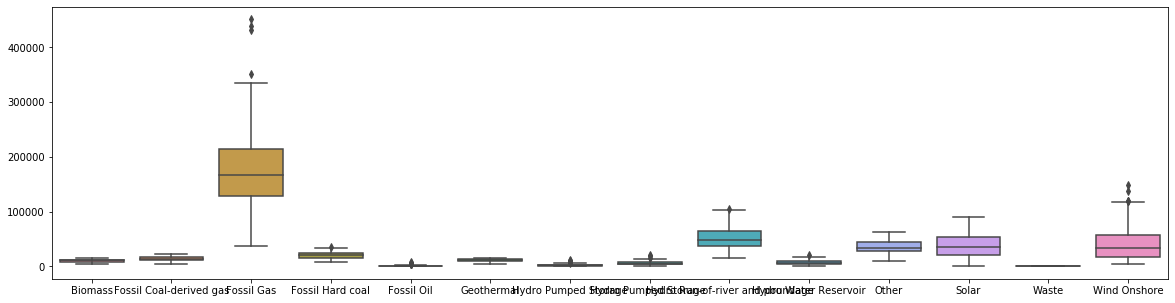

In [20]:
plt.figure(figsize=(20,5))
df = df.set_index('daytime')

sns.boxplot(data=df[df.columns.drop('sum')])